In [1]:
import sys
sys.path.append('..')

In [2]:
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
ckpt = '2408/Hagen-sr3-vanilla/56'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2408/Hagen-sr3-vanilla/56'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

/group/jug/ashesh/training/diffsplit/2408/Hagen-sr3-vanilla/56/checkpoint/I70000_E875


In [5]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
# from tensorboardX import SummaryWriter
import os
# Convert to NoneDict, which return None for missing key.

# logging

patch_size = opt['datasets']['train']['patch_size']
train_data_location = DataLocation(channelwise_fpath=(opt['datasets']['train']['datapath']['ch0'],
                                                opt['datasets']['train']['datapath']['ch1']))

train_set = SplitDataset(train_data_location, patch_size, normalization_dict=None, enable_transforms=True,random_patching=True)
# train_loader = Data.create_dataloader(train_set, opt['datasets']['train'], 'train')

patch_size = opt['datasets']['val']['patch_size']
val_data_location = DataLocation(channelwise_fpath=(opt['datasets']['val']['datapath']['ch0'],
                                                opt['datasets']['val']['datapath']['ch1']))
val_set = SplitDataset(val_data_location, patch_size, normalization_dict=train_set.get_normalization_dict(),
                        enable_transforms=False,
                                                    random_patching=False)
# val_loader = Data.create_dataloader(val_set, opt['datasets']['val'], 'val')
# model
diffusion = Model.create_model(opt)


diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


Computing mean and std for normalization


INFO:base:Initialization method [orthogonal]


[SplitDataset] Data: 20x2x(2048, 2048)               Patch:512 Random:1 Aug:True
[SplitDataset] Data: 20x2x(2048, 2048)               Patch:512 Random:0 Aug:False


INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2408/Hagen-sr3-vanilla/56/checkpoint/I70000_E875] ...
INFO:base:Network G structure: GaussianDiffusion, with parameters: 2,438,481
INFO:base:GaussianDiffusion(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=16, out_features=64, bias=True)
      (2): Swish()
      (3): Linear(in_features=64, out_features=16, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=16, out_features=16, bias=True)
            )
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(16, 16, eps=1e-05, affine=True)
              (1): Swish()
              (2): Identity()
  

In [6]:
diffusion.load_network()

INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2408/Hagen-sr3-vanilla/56/checkpoint/I70000_E875] ...


In [7]:
(1 | (diffusion.netG.num_timesteps//10)) 

201

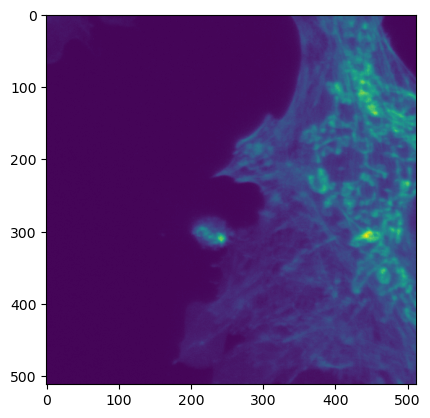

In [20]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0,len(val_set))
data = val_set[idx]
inp = data['input']
target = data['target']
diffusion_data = {'input': torch.Tensor(inp)[None].cuda(), 'target': torch.Tensor(target[None]).cuda()}
plt.imshow(inp[0])

In [21]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')
diffusion.feed_data(diffusion_data)
diffusion.test(continous=False, clip_denoised=True)
visuals = diffusion.get_current_visuals()
# input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
input = visuals['input']
target = visuals['target']
prediction = visuals['prediction']


sampling loop time step: 100%|██████████| 2000/2000 [00:31<00:00, 62.73it/s]


In [22]:
diffusion

TypeError: Invalid shape (512,) for image data

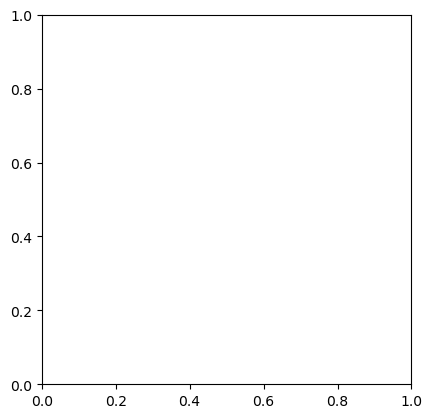

In [23]:
plt.imshow(prediction[0,0])

IndexError: index 1 is out of bounds for dimension 0 with size 1

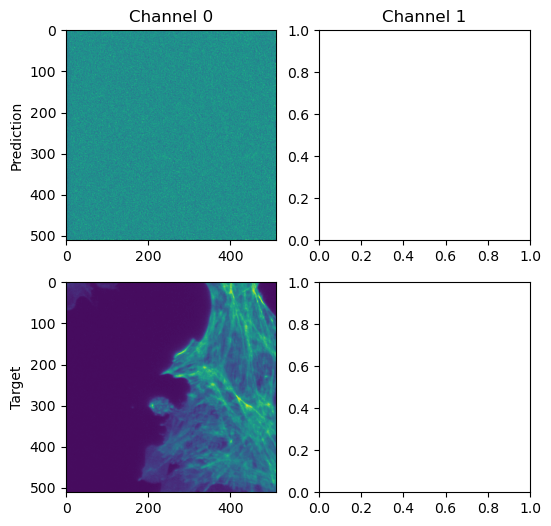

In [24]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax

_,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
ax[0,0].set_ylabel('Prediction')
ax[1,0].set_ylabel('Target')
ax[0,0].set_title('Channel 0')
ax[0,1].set_title('Channel 1')
ax[0,0].imshow(prediction[0].cpu().numpy())
ax[1,0].imshow(target[0,0].cpu().numpy())

ax[0,1].imshow(prediction[1].cpu().numpy())
ax[1,1].imshow(target[0,1].cpu().numpy())
clean_ax(ax)